# Import the Necessary Libraries

In [1]:
# Data and Plotting
import pandas as pd
import numpy as np
import plotly.express as px
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

# Data encoding and Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Dimensionality Reduction and Clustering Algorithms
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

# Data spliting and Cross Validation and Performance Metrics
from sklearn.model_selection import train_test_split as tts, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import  make_scorer,  precision_score, accuracy_score

# models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier as FNN

%matplotlib notebook

# Load the Dataset

In [2]:
data = pd.read_csv("Thyroid_Diff.csv")

X = data.drop("Recurred", axis=1)
y = data["Recurred"]
y = y.map({"No":0,"Yes":1})

X_train, X_test, y_train, y_test = tts(X, y, 
                                       train_size=.7, 
                                       random_state=321
                                      )
y_train.value_counts()

Recurred
0    194
1     74
Name: count, dtype: int64

# Define the Steps that are Common to all Three Methods

## a. The Data Preprocessing Step

In [3]:
# Define preprocessor
num_features = list(X.columns[:1])
cat_features = list(X.columns[1:])

# Define the numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ("scaler", MinMaxScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
])

# Define your ColumnTransformer (preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder="passthrough",
)

## b. Define the Models and Metrics

In [4]:
# Define the models
models = {
    "RF": RFC(),
    "GBC": GBC(),
    "SVM": SVC(probability=True),
    "LR": LR(),
    "KNN": KNN(),
    "FNN": FNN(),
}

# Define the list of metrics for model evaluation on test set
metrics = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Score": f1_score,
    "ROC AUC": roc_auc_score,
    "Sensitivity": recall_score,
    "Specificity": recall_score,
    "Precision": precision_score
}

# Define the list of metrics for models evaluation using 10-fold CV
# Since specificity score is not directly included in sklearn, we create it using the make_scorer function
specificity = make_scorer(recall_score, pos_label=0) 
sensitivity = make_scorer(recall_score, pos_label=1)

ten_fold_CV_metrics = {
    "Balanced Accuracy": "balanced_accuracy",
    "F1 Score": "f1_macro",
    "ROC AUC": "roc_auc",
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "Precision": "precision"
}

# Complete range of Hyperparameters optimised for each model both in the PCA and tSVD decomposition pipelines

In [5]:
# These hyperparameters were tested before fine-tuning each one at finer granularity to improve model performance
param_grids = {
    "RF": {
        "clf__n_estimators": [200, 300, 400, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__criterion": ["gini", "entropy", "log_loss"],
        "clf__class_weight": [{0: 1, 1: 1}, {0: 1, 1: 3}, {0: 1, 1: 5}],
        "clf__max_features": ["sqrt", "log2"], 
    },
    "GBC": {
        "clf__n_estimators": [100, 200, 300],
        "clf__loss": ["log_loss", "exponential"],
        "clf__learning_rate": [0.1, 0.3, 0.5],
        "clf__max_depth": [3, 5],
        "clf__criterion": ["friedman_mse", "squared_error"],
        "clf__tol": [1e-2, 1e-4, 1e-7, 1e-10]
    },
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf", "sigmoid", "poly"],
        "clf__tol": [1e-2, 1e-3, 1e-7, 1e-10],
        
    },
    "LR": {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l1", "l2", "elasticnet"],
        "clf__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
    },
    "KNN": {
        "clf__n_neighbors": [14, 15, 16, 18],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2]
    },
    "FNN": {
        "clf__hidden_layer_sizes": [(100,), (50, 50), (100, 100)],
        "clf__max_iter": [2500, 2750, 3000],
        "clf__activation": ["relu", "tanh", "logistic", "identity"], 
        "clf__solver": ["adam", "sgd", "lbfgs"],
        "clf__learning_rate": ["constant", "invscaling", "adaptive"],
        "clf__tol": [1e-2, 1e-4, 1e-7, 1e-10]
    }
}

# Method 1: Dimensionality Reduction with PCA

## a. Hyperparameter tuning, model building and evaluation on testing set

In [6]:
# Note: Subset of the hyperparameters with better performance. Continue to titrate them at finer granularity 
# and compare the performances of the models
param_grids = {
    "RF": {
        "clf__n_estimators": [300, 400, 600],
        "clf__min_samples_split": [5, 6],
        "clf__min_samples_leaf": [4, 5, 6],
        "clf__criterion": ["gini"],
        "clf__class_weight": [{0: 1, 1: 1}],
        "clf__max_features": ["log2"], 
    },
    "GBC": {
        "clf__n_estimators": [100, 200],
        "clf__loss": ["exponential"],
        "clf__learning_rate": [0.3, 0.4],
        "clf__max_depth": [3],
        "clf__criterion": ["squared_error"],
        "clf__tol": [1e-10, 1e-12]
    },
    "SVM": {
        "clf__C": [0.1, 0.2, 0.3],
        "clf__kernel": ["rbf", "sigmoid"],
        "clf__tol": [1e-1, 1e-2, 1e-3],
        
    },
    "LR": {
        "clf__C": [0.1, 0.2, 0.3],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear", "saga"]
    },
    "KNN": {
        "clf__n_neighbors": [15, 16, 17],
        "clf__weights": ["distance"],
        "clf__p": [2, 3, 4]
    },
    "FNN": {
        "clf__hidden_layer_sizes": [(100,), (100, 100), (200, 200)],
        "clf__max_iter": [2500, 2750],
        "clf__activation": ["relu", "identity"], 
        "clf__solver": ["adam", "sgd", "lbfgs"],
        "clf__learning_rate": ["constant", "adaptive"],
        "clf__tol": [1e-1, 1e-2]
    }
}

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the best Dimensionality Reduction Technique from Method 3
pca = PCA(n_components=5)

# Store results
method_1_results = {}

for model_name, model in models.items():
    print(f"\rEvaluating {model_name}...", end="", flush=True)
    
    # Combine the dimensionality reduction, and model into a pipeline
    pipeline = Pipeline(
        steps = [
            ("preprocessor", preprocessor),
            ("pca", pca),
            ("clf", model),
        ])
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=skf, scoring="roc_auc")
    grid_search.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metric_results = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC":
            metric_results[metric_name] = metric_func(y_test, y_pred_proba)
        elif metric_name == "Specificity":
            metric_results[metric_name] = metric_func(y_test, y_pred, pos_label=0)
        else:
            metric_results[metric_name] = metric_func(y_test, y_pred)
    
    # Store results
    method_1_results[model_name] = {
        "best Clf": best_pipeline,
        "Best Parameters": grid_search.best_params_,
        "Best ROC-AUC Score": grid_search.best_score_,
        "Metrics": metric_results
    }
    print(f"\rEvaluation completed for {model_name}")

print("All Evaluation completed.")

Evaluation completed for RF
Evaluation completed for GBC
Evaluation completed for SVM
Evaluation completed for LR
Evaluation completed for KNN
Evaluation completed for FNN

Evaluation completed.


In [7]:
# Print results
for model_name, result in method_1_results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Best ROC-AUC Score: {result['Best ROC-AUC Score']}")
    # print(f"Best Model: {result['best Clf']}")
#     for metric_name, score in result["Metrics"].items():
#         print(f"{metric_name}: {score}")


RF Results:
Best Parameters: {'clf__class_weight': {0: 1, 1: 1}, 'clf__criterion': 'gini', 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5, 'clf__n_estimators': 600}
Best ROC-AUC Score: 0.9418520660625923

GBC Results:
Best Parameters: {'clf__criterion': 'squared_error', 'clf__learning_rate': 0.4, 'clf__loss': 'exponential', 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__tol': 1e-12}
Best ROC-AUC Score: 0.9306368485315852

SVM Results:
Best Parameters: {'clf__C': 0.1, 'clf__kernel': 'sigmoid', 'clf__tol': 0.001}
Best ROC-AUC Score: 0.938604202814729

LR Results:
Best Parameters: {'clf__C': 0.2, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best ROC-AUC Score: 0.9449122807017544

KNN Results:
Best Parameters: {'clf__n_neighbors': 15, 'clf__p': 2, 'clf__weights': 'distance'}
Best ROC-AUC Score: 0.9347117794486215

FNN Results:
Best Parameters: {'clf__activation': 'identity', 'clf__hidden_layer_sizes': (100, 100), 'clf__learning_rate': 'adaptive

In [8]:
performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in method_1_results.items():
    # print(model_name)
    for metric_name, score in result["Metrics"].items():
        # print(metric_name, ":", score)
        performance_metrics[metric_name].append(score)

df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Models", [model_name for model_name in models])
df_performance = df_performance.round(3)
df_performance.to_csv("results/test set models performance using PCA.csv", index=False)
df_performance

,Models,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.914,0.892,0.983,0.853,0.975,0.935
1,GBC,0.877,0.817,0.963,0.853,0.901,0.784
2,SVM,0.919,0.873,0.985,0.912,0.926,0.838
3,LR,0.929,0.909,0.989,0.882,0.975,0.938
4,KNN,0.896,0.853,0.982,0.853,0.938,0.853
5,FNN,0.937,0.912,0.987,0.912,0.963,0.912


# b. 10-fold CV using the entire dataset

In [9]:
# Set up Stratified K-Fold Cross-Validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

ten_fold_cv_results_method_1 = {}

for model_name, result in method_1_results.items():
    print(f"\rRunning {n_splits}-fold CV for {model_name}...", end="", flush=True)
    model = result['best Clf']
    cv_results = cross_validate(model, X, y, cv=skf, scoring=ten_fold_CV_metrics, return_train_score=False)
    
    metric_ids = [metric_id for metric_id in cv_results.keys() if metric_id.startswith("test_")]
    scores = {name: cv_results[metric_id] for name, metric_id in zip(ten_fold_CV_metrics.keys(), metric_ids)}
    
    ten_fold_cv_results_method_1[model_name] = scores
    
    print(f"\rCompleted {n_splits}-fold CV for {model_name}")

print(f"\rAll {n_splits}-fold CV Completed")


performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in ten_fold_cv_results_method_1.items():
    for metric_name, score in result.items():
        performance_metrics[metric_name].append(np.mean(score))
        
df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Model", [model_name for model_name in models])   
df_performance = df_performance.round(3)

df_performance.to_csv("results/10-fold CV performance using PCA.csv", index=False)
df_performance

Completed 10-fold CV for RF.
Completed 10-fold CV for GBC.
Completed 10-fold CV for SVM.
Completed 10-fold CV for LR.
Completed 10-fold CV for KNN.
Completed 10-fold CV for FNN.
All 10-fold CV Completed


,Model,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.865,0.874,0.958,0.776,0.953,0.876
1,GBC,0.868,0.868,0.946,0.805,0.931,0.834
2,SVM,0.867,0.858,0.956,0.833,0.902,0.776
3,LR,0.850,0.854,0.962,0.768,0.931,0.823
4,KNN,0.864,0.871,0.963,0.786,0.942,0.850
5,FNN,0.837,0.840,0.954,0.750,0.924,0.804


# Method 2: Oversampling and tSVD

## a. Hyperparameter tuning, model building and evaluation on testing set

In [10]:
# Note: Subset of the hyperparameters with better performance. Continue to titrate them at finer granularity 
# and compare the performances of the models

param_grids = {
    "RF": {
        "clf__n_estimators": [300, 400],
        "clf__max_depth": [None, 10],
        "clf__min_samples_split": [5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__criterion": ["gini", "entropy"],
        "clf__class_weight": [{0: 1, 1: 3}],
        "clf__max_features": ["log2"], 
    },
    "GBC": {
        "clf__n_estimators": [100, 120],
        "clf__loss": ["log_loss", "exponential"],
        "clf__learning_rate": [0.3, 0.4],
        "clf__max_depth": [3, 4],
        "clf__criterion": ["friedman_mse", "squared_error"],
        "clf__tol": [1e-10, 1e-11]
    },
    "SVM": {
        "clf__C": [0.1, 0.15, 0.2],
        "clf__kernel": [ "rbf", "sigmoid"],
        "clf__tol": [1e-2, 1e-3],
        
    },
    "LR": {
        "clf__C": [0.1, 0.2, 0.3],
        "clf__penalty": ["l1", "l2", "elasticnet"],
        "clf__solver": ["lbfgs", "liblinear", "saga"]
    },
    "KNN": {
        "clf__n_neighbors": [16, 17],
        "clf__weights": ["distance"],
        "clf__p": [2, 3, 4]
    },
    "FNN": {
        "clf__hidden_layer_sizes": [(100,), (50, 50)],
        "clf__max_iter": [2500, 2750],
        "clf__activation": ["relu", "logistic", "identity"], 
        "clf__solver": ["adam", "sgd"],
        "clf__learning_rate": ["adaptive"],
        "clf__tol": [1e-2, 1e-3]
    }
}

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Define the best Dimensionality Reduction Technique from Method 3
t_svd = TruncatedSVD(n_components=5)

# Store results
method_2_results = {}

for model_name, model in models.items():
    print(f"\rEvaluating {model_name}...", end="", flush=True)
    
    # Combine the preprocessing, oversampling, noise filtering, dimensionality reduction, and model into a pipeline
    pipeline = Pipeline(
        steps = [
            ("preprocessor", preprocessor),
            ("t-svd", t_svd),
            ("clf", model),
        ])
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=skf, scoring="roc_auc")
    grid_search.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metric_results = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC":
            metric_results[metric_name] = metric_func(y_test, y_pred_proba)
        elif metric_name == "Specificity":
            metric_results[metric_name] = metric_func(y_test, y_pred, pos_label=0)
        else:
            metric_results[metric_name] = metric_func(y_test, y_pred)
    
    # Store results
    method_2_results[model_name] = {
        "best Clf": best_pipeline,
        "Best Parameters": grid_search.best_params_,
        "Best ROC-AUC Score": grid_search.best_score_,
        "Metrics": metric_results
    }
    print(f"\rEvaluation completed for {model_name}")

print("Evaluation completed.")

Evaluation completed for RF
Evaluation completed for GBC
Evaluation completed for SVM
Evaluating LR...

C:\Users\HP\anaconda3\envs\dl_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\HP\anaconda3\envs\dl_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\HP\anaconda3\envs\dl_env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
24 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\envs\dl_env\lib\site-packages\sklearn\model_selection\_validation.py

Evaluation completed for LR
Evaluation completed for KNN
Evaluation completed for FNN

Evaluation completed.


In [11]:
# Print results
for model_name, result in method_2_results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Best ROC-AUC Score: {result['Best ROC-AUC Score']}")
#     for metric_name, score in result["Metrics"].items():
#         print(f"{metric_name}: {score}")


RF Results:
Best Parameters: {'clf__class_weight': {0: 1, 1: 3}, 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}
Best ROC-AUC Score: 0.9421844524937308

GBC Results:
Best Parameters: {'clf__criterion': 'friedman_mse', 'clf__learning_rate': 0.4, 'clf__loss': 'exponential', 'clf__max_depth': 4, 'clf__n_estimators': 120, 'clf__tol': 1e-11}
Best ROC-AUC Score: 0.9382836444692115

SVM Results:
Best Parameters: {'clf__C': 0.2, 'clf__kernel': 'rbf', 'clf__tol': 0.001}
Best ROC-AUC Score: 0.9458066313736416

LR Results:
Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best ROC-AUC Score: 0.9452493730844247

KNN Results:
Best Parameters: {'clf__n_neighbors': 16, 'clf__p': 2, 'clf__weights': 'distance'}
Best ROC-AUC Score: 0.9394678183337979

FNN Results:
Best Parameters: {'clf__activation': 'identity', 'clf__hidden_layer_sizes': (100,), 'clf__learnin

In [12]:
performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in method_2_results.items():
    # print(model_name)
    for metric_name, score in result["Metrics"].items():
        # print(metric_name, ":", score)
        performance_metrics[metric_name].append(score)

df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Models", [model_name for model_name in models])
df_performance = df_performance.round(3)
df_performance.to_csv("results/test set models performance using tSVD.csv", index=False)
df_performance

,Models,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.942,0.892,0.985,0.971,0.914,0.825
1,GBC,0.916,0.882,0.980,0.882,0.951,0.882
2,SVM,0.937,0.912,0.987,0.912,0.963,0.912
3,LR,0.929,0.909,0.990,0.882,0.975,0.938
4,KNN,0.916,0.882,0.986,0.882,0.951,0.882
5,FNN,0.923,0.896,0.982,0.882,0.963,0.909


## b. 10-fold CV using the entire dataset

In [13]:
# Set up Stratified K-Fold Cross-Validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

ten_fold_cv_results_method_2 = {}

for model_name, result in method_2_results.items():
    print(f"\rRunning {n_splits}-fold CV for {model_name}...", end="", flush=True)
    model = result['best Clf']
    cv_results = cross_validate(model, X, y, cv=skf, scoring=ten_fold_CV_metrics, return_train_score=False)
    
    metric_ids = [metric_id for metric_id in cv_results.keys() if metric_id.startswith("test_")]
    scores = {name: cv_results[metric_id] for name, metric_id in zip(ten_fold_CV_metrics.keys(), metric_ids)}
    
    ten_fold_cv_results_method_2[model_name] = scores
    
    print(f"\rCompleted {n_splits}-fold CV for {model_name}")

print(f"\rAll {n_splits}-fold CV Completed")


performance_metrics = {metric_name: [] for metric_name in metrics.keys()}

for model_name, result in ten_fold_cv_results_method_2.items():
    for metric_name, score in result.items():
        performance_metrics[metric_name].append(np.mean(score))
        
df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Model", [model_name for model_name in models])   
df_performance = df_performance.round(3)

df_performance.to_csv("results/10-fold CV models performance using tSVD.csv", index=False)
df_performance

Completed 10-fold CV for RF.
Completed 10-fold CV for GBC.
Completed 10-fold CV for SVM.
Completed 10-fold CV for LR.
Completed 10-fold CV for KNN.
Completed 10-fold CV for FNN.
All 10-fold CV Completed


,Model,Balanced Accuracy,F1 Score,ROC AUC,Sensitivity,Specificity,Precision
0,RF,0.889,0.884,0.960,0.850,0.928,0.828
1,GBC,0.869,0.872,0.956,0.796,0.942,0.843
2,SVM,0.851,0.852,0.955,0.777,0.924,0.808
3,LR,0.853,0.860,0.961,0.768,0.938,0.840
4,KNN,0.863,0.872,0.954,0.777,0.949,0.868
5,FNN,0.842,0.855,0.960,0.731,0.953,0.873


# ROC and Detection Error Tradeoff (DET) curves, (Method 1 and Method 2)

<IPython.core.display.Javascript object>


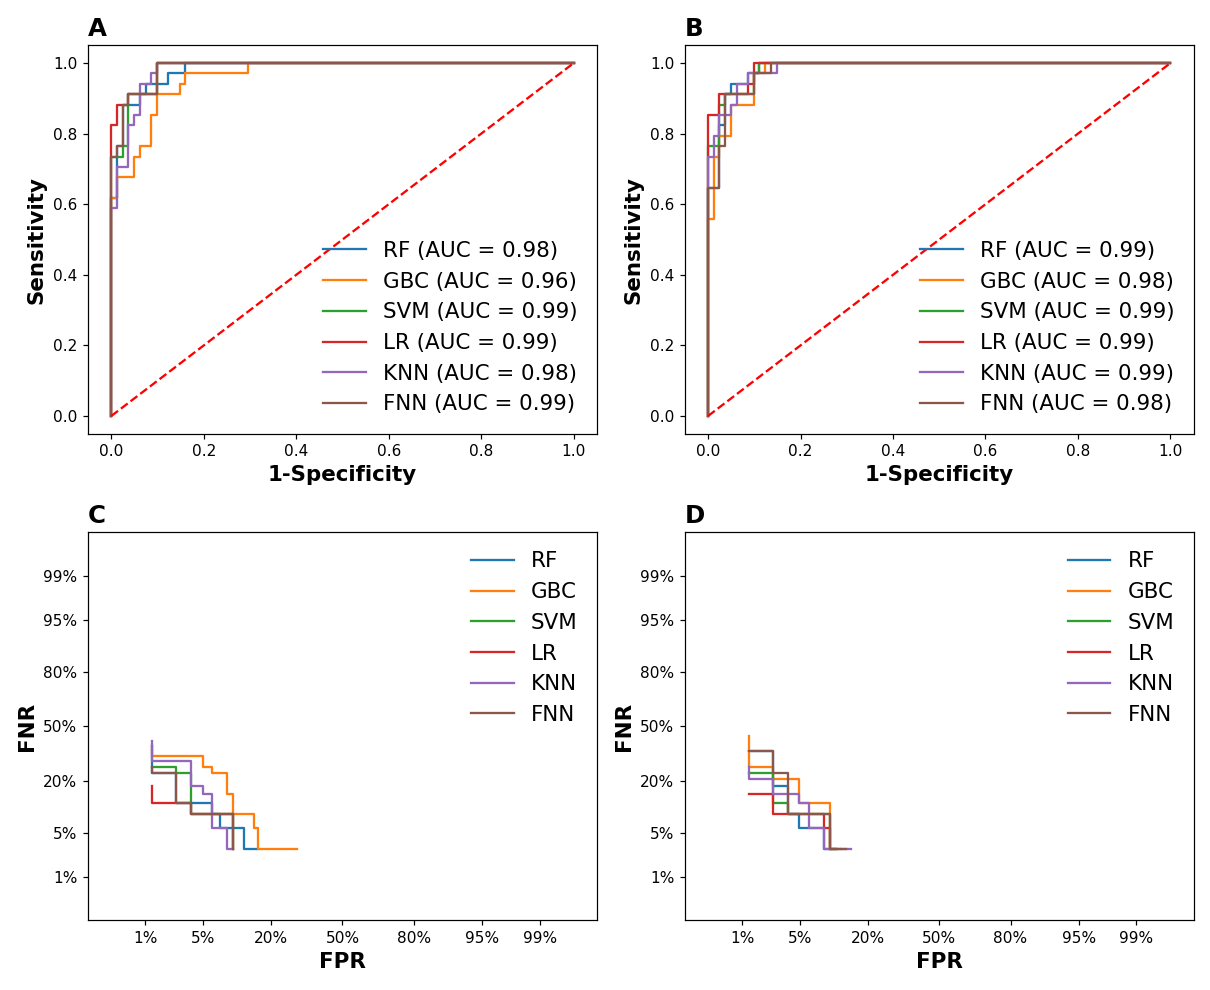

In [14]:
clfs_pca = [result["best Clf"] for model_name, result in method_1_results.items()]
clfs_tsvd = [result["best Clf"] for model_name, result in method_2_results.items()]

model_names = [model_name for model_name, result in method_1_results.items()]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

for clf_pca, clf_tsvd, model_name in zip(clfs_pca, clfs_tsvd, model_names):
    # Plot the ROC curves
    RocCurveDisplay.from_estimator(clf_pca, X_test, y_test, ax=ax1, name=model_name)
    RocCurveDisplay.from_estimator(clf_tsvd, X_test, y_test, ax=ax2, name=model_name)
    # Plot the DET curves
    DetCurveDisplay.from_estimator(clf_pca, X_test, y_test, ax=ax3, name=model_name)
    DetCurveDisplay.from_estimator(clf_tsvd, X_test, y_test, ax=ax4, name=model_name)

ax1.set_title("A", fontsize=16, loc="left", fontweight="bold")
ax1.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
ax1.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
ax1.plot([0, 1], [0, 1], "r--")  # adding a diagonal
ax1.legend(fontsize=14, frameon=False)
ax1.grid(False)

ax2.set_title("B", fontsize=16, loc="left", fontweight="bold")
ax2.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
ax2.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
ax2.plot([0, 1], [0, 1], "r--")  # adding a diagonal
ax2.legend(fontsize=14, frameon=False)
ax2.grid(False)

ax3.set_title("C", fontsize=16, loc="left", fontweight="bold")
ax3.set_xlabel("FPR", fontsize=14, fontweight="bold")
ax3.set_ylabel("FNR", fontsize=14, fontweight="bold")
ax3.legend(fontsize=14, frameon=False)
ax3.grid(False)

ax4.set_title("D", fontsize=16, loc="left", fontweight="bold")
ax4.set_xlabel("FPR", fontsize=14, fontweight="bold")
ax4.set_ylabel("FNR", fontsize=14, fontweight="bold")
ax4.legend(fontsize=14, frameon=False)
ax4.grid(False)

fig.tight_layout()
plt.savefig("results/ROC and DET Curves for PCA and tSVD on Training Set.TIFF", dpi=1200)
plt.show()